# Assignment 2

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install category_encoders

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import category_encoders as ce
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

from random import randint
from numpy import linalg
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVR
from sklearn import neighbors

from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor

import statsmodels.formula.api as sf
cur_dir = os.getcwd()

## Import the dataset

In [3]:
Salaries = pd.read_csv('kaggle_salary.csv', header=0, skiprows=[1])

C:\Users\natal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (209,323,372,385,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I will be removing several columns that are not important to the regression analysis to determine Salary. Several of the columns are for "OTHER_TEXT". These columns are where the respondent typed in their own answer if they chose "other", however instead of text, this column just gives sequential numbers. These numbers don't give any information or add anything to the analysis so they can be removed. Additionally, Q18, "What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice", has nothing to do with the respondent's salary so it can be removed.

In [4]:
drop_col = ['Unnamed: 0', 'Q1_OTHER_TEXT', 'Q6_OTHER_TEXT', 'Q7_OTHER_TEXT', 'Q11_OTHER_TEXT', 'Q12_MULTIPLE_CHOICE',
            'Q13_OTHER_TEXT', 'Q14_OTHER_TEXT', 'Q15_OTHER_TEXT', 'Q16_OTHER_TEXT', 'Q17_OTHER_TEXT', 'Q18',
            'Q18_OTHER_TEXT', 'Q19_OTHER_TEXT', 'Q20_OTHER_TEXT', 'Q21_OTHER_TEXT', 'Q22_OTHER_TEXT', 'Q27_OTHER_TEXT', 
            'Q28_OTHER_TEXT', 'Q29_OTHER_TEXT', 'Q30_OTHER_TEXT', 'Q31_OTHER_TEXT', 'Q33_OTHER_TEXT', 'Q34_OTHER_TEXT', 
            'Q35_OTHER_TEXT', 'Q36_OTHER_TEXT', 'Q37_OTHER_TEXT', 'Q38_OTHER_TEXT', 'Q42_OTHER_TEXT', 'Q49_OTHER_TEXT', 
            'Q50_OTHER_TEXT', 'index']

Salaries.drop(drop_col, axis=1, inplace=True)

Salaries.rename(columns={'Time from Start to Finish (seconds)' : 'duration',
                          'Q1':'gender',
                          'Q2':'age',
                          'Q3':'country',
                          'Q4' : 'education',
                          'Q5' : 'major',
                          'Q6' : 'title',
                          'Q7' : 'industry',
                          'Q8' : 'experience',
                          'Q9' : 'salary'}, 
                 inplace=True)

In [5]:
Salaries.shape

(15429, 365)

## 1. Data Cleaning 
### Row and Column Elimination

The duration for each row indicates how long the respondent spent answering the Kaggle Survey in seconds. Since it is a fairly lengthy survey, respondents who took less than around 8 minutes to take the survey were dropped. These respondents had several missing values because the respondent most likely did not answer all of the questions, and did not give sufficient time to think about their answers. Additionally, respondents who took longer than 5 hours were dropped. Most likely the respondent started the survey, then forgot to continue the survey. Once this was done, the duration column was dropped because the length of time it takes a respondent to complete the survey is not related to their Salary, so it is no longer needed.

I also dropped respondents who were 80 years old or older. This was a very small number of respondents, and did not seem very realistic, or like these respondents would give very meaningful data.

In [6]:
# Drop respondents who took less than 500 seconds to answer the survey
duration_LB = Salaries[Salaries.duration.astype(int) <= 500].index
Salaries = Salaries.drop(duration_LB, axis=0)

# Drop respondents who took more than 18000 seconds to answer the survey
duration_UB = Salaries[Salaries.duration.astype(int) >= 18000].index
Salaries = Salaries.drop(duration_UB, axis=0)

# Drop duration - this column is no longer needed because Salary is not dependent on survey duration
Salaries = Salaries.drop(['duration'], axis=1)

# Drop respondents whose age is 80+ - does not seem realistic that there are 80+ year olds in data science field
old = Salaries[Salaries.age == '80+'].index
Salaries = Salaries.drop(old, axis=0)

Salaries.reset_index(drop=True, inplace=True)

I defined a row and column threshold equal to 10% of the total number of columns and rows respectively. This 10% is the minimum amount of data that must be present in the row/column. This would drop rows with 90% of the columns empty, meaning the respondent did not answer most of the questions, and columns with 90% of the rows empty, meaning 90% of respondents did not answer the question, or select that multiple choice option. 

In [7]:
# Eliminate rows that are 90% empty
row_thresh = round(0.1*len(Salaries.columns))

# Eliminate columns that are 90% empty 
col_thresh = round(0.1*len(Salaries.index))

# Drop rows and columns that are 90% empty
Salaries.dropna(axis=0, how='any', thresh=row_thresh, subset=None, inplace=True)
Salaries.dropna(axis=1, how='any', thresh=col_thresh, subset=None, inplace=True)

In [8]:
Salaries.shape

(11410, 182)

Since students make low income and do not have much experience, it introduced bias into the results. If we want to analyze salaries for a data scientist, it makes sense to drop respondents who are students and have not entered the workforce yet.

Additionally, most of the missing values for experience are because the respondent is a student or just started their career. Since there are very few of these, it is safe  to drop these respondents from the analysis. 

In [9]:
# Drop students
students = Salaries[Salaries['industry'] == 'I am a student'].index
Salaries = Salaries.drop(students, axis=0)

students2 = Salaries[Salaries['title'] == 'Student'].index
Salaries = Salaries.drop(students2, axis=0)

# Drop rows with missing experience values
Salaries = Salaries.dropna(subset=['experience'])

Country is a very important factor in determining Salary. Additionally, I want to engineer a new feature by converting country to a numerical value, Gross Domestic Product (GDP) per capita. Therefore, the country categories 'I do not wish to disclose my location' and 'Other' were dropped. 

In [10]:
country_drop = Salaries[Salaries['country'] == 'I do not wish to disclose my location'].index
Salaries = Salaries.drop(country_drop, axis=0)

country_drop2 = Salaries[Salaries['country'] == 'Other'].index
Salaries = Salaries.drop(country_drop2, axis=0)

Next, drop countries who have 35 or less respondents. Only 35 respondents per country, does not give very good insight into the skills required, job titles, education needed to have a higher salary. Also, the combined number of respondents for these countries is under 5% of the total number of respondents. Therefore, removing these countries will have little to no effect on the analysis. 

In [11]:
country_count = Salaries.country.value_counts()
small_country = Salaries.country.isin(country_count.index[country_count <= 35])
small_country_index = Salaries.loc[small_country].index
Salaries = Salaries.drop(small_country_index, axis=0)
Salaries.reset_index(drop=True, inplace=True)

print(str(round((len(small_country_index)/len(Salaries))*100, 2)) + "%")

4.01%


### Dealing with missing values

All of the missing values for major are because the respondent has no formal education past high school. Therefore, it does not make sense to fill these missing values with the mode, or with "other". In this case, I will put 0 as the major. The regression will effectively skip over this category for these respondents. 

In [12]:
# Fill missing values for major with 0
Salaries['major'].fillna(value=0, inplace=True)

Several questions are dependent on previous questions answered. Therefore, the missing values for these questions can be found using the modes of the reference question.
For example, Q20 - Of the choices that you selected in the previous question, which ML library have you used the most? 
Reference: Q19 - What machine learning frameworks have you used in the past 5 years? 

Basics of how the fill_na_mode functions works:

1. Create a list of columns from the reference question defined by Qref. Each column represents each part of the question. Example Q19_PART1 would be the first column for Q19.
2. the response choice for each question part is found and put in the variable 'option'. In the example, for Q19_Part1 the option selected would be 'Scikit-Learn'
3. The mode for the Q20 answers is found for each response choice. Example, respondents who chose 'Scikit-Learn' as one of their ML frameworks used in the last 5 years, were most likely to choose 'Scikit-Learn' as their ML library used the most for Q20.
4. If the Qref question is still empty, this means the respondent did not give an answer for any parts of the reference question, therefore the value for the column was set to 0.

If Qfill and Qref are the same, then the NaNs are simply filled with the mode of the specified column, effectively referencing itself to fill missing values.

In [13]:
def fill_na_mode(Qfill, Qref):
    
    '''Qfill is the question with NaNs that need to be filled. Qref is the question that youre using to base the mode off'''
    
    if Qfill == Qref:
        option_mode = Salaries[Qfill].mode()[0]
        Salaries[Qfill].fillna(option_mode, inplace=True)
    
    else:
        Salaries[Qfill].fillna(value='empty', inplace=True) 
        Q_col_list = []
        for index in Salaries.columns:
            if index.startswith(Qref) == True:
                Q_col_list.append(index)
        
        for col in Q_col_list:
            labels = Salaries[col].astype('category').cat.categories.tolist()
            option_mode = Salaries[Qfill].loc[Salaries[col] == labels[0]].mode()[0]
            
            replaced_rows =[]
            for row in Salaries[Qfill].loc[Salaries[col] == labels[0]]:
                row = row.replace('empty', option_mode)
                replaced_rows.append(row)
            
            Salaries[Qfill].loc[Salaries[col] == labels[0]] = replaced_rows
        
        Salaries[Qfill].replace('empty', 0, inplace=True)

Q17 - What specific programming language do you use most often? 
reference: Q16 - What programming languages do you use on a regular basis? 

Q26 - Do you consider yourself to be a data scientist? 
reference: job title 

In [14]:
fill_na_mode(Qfill='Q17', Qref='Q16')
fill_na_mode(Qfill='Q20', Qref='Q19')
fill_na_mode(Qfill='Q22', Qref='Q21')
fill_na_mode(Qfill='Q26', Qref='title')
fill_na_mode(Qfill='Q32', Qref='Q31')
fill_na_mode(Qfill='Q37', Qref='Q36')
fill_na_mode(Qfill='Q46', Qref='Q45')

# fill NaNs for Q23, Q24, Q25, Q26, Q48 using the mode
fill_na_mode(Qfill='Q23', Qref='Q23')
fill_na_mode(Qfill='Q24', Qref='Q24')
fill_na_mode(Qfill='Q25', Qref='Q25')
fill_na_mode(Qfill='Q26', Qref='Q26')

#fill_na_mode(Qfill='Q43', Qref='Q42')
fill_na_mode(Qfill='Q48', Qref='Q28')

fill_na_mode(Qfill='Q39_Part_1', Qref='Q39_Part_1')
fill_na_mode(Qfill='Q39_Part_2', Qref='Q39_Part_2')
fill_na_mode(Qfill='Q40', Qref='Q40')
fill_na_mode(Qfill='Q41_Part_1', Qref='Q41_Part_1')
fill_na_mode(Qfill='Q41_Part_2', Qref='Q41_Part_2')
fill_na_mode(Qfill='Q41_Part_3', Qref='Q41_Part_3')

C:\Users\natal\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


When metrics that consider unfair bias are used to determine success, then 0-10% and 10-20% of data projects involve exploring unfair bias in the dataset and/or algorithm. 0-10 and 10-20 value counts are almost even. Therefore, for Q43, I will use a value of 10 for the NaNs thats used this answer on Q42 Part 3

In [15]:
#Q42 Part3 and Q43 are asking about unfair bias. 
Salaries['Q43'].loc[Salaries['Q42_Part_3'] == 'Metrics that consider unfair bias'].fillna(value=10, inplace=True)
# Fill the remaining NaNs with the mode
fill_na_mode(Qfill='Q43', Qref='Q43')

Q34 is asking the respondent to approximate the percentage of their time devoted to different data science tasks, and Q35 is asking the respondent to approximate what percentage of their current ML/data science trainining falls under different categories. The response for each question must sum to 100%, therefore it makes sense to fill the NaNs with the mean value for each column of each question.

First, I found the mean value for each column of the question, then I added them all up to see if it equaled 100%. For Q35, the means added to 100% however for Q34 they did not.

In [16]:
Q34 = []
for index in Salaries.columns:
    if index.startswith('Q34') == True:
        Q34.append(index)

Q35 = []
for index in Salaries.columns:
    if index.startswith('Q35') == True:
        Q35.append(index)

total34 = 0
for q in Q34:
    print(q + ':')
    print('the mean value is '+ str(round(Salaries[q].mean())))
    total34 += round(Salaries[q].mean())
    
print('the total is ' + str(total34))
print('\n')

total = 0
for q in Q35:
    print(q + ':')
    print('the mean value is '+ str(round(Salaries[q].mean())))
    total += round(Salaries[q].mean())
    
print('the total is ' + str(total))

Q34_Part_1:
the mean value is 17
Q34_Part_2:
the mean value is 24
Q34_Part_3:
the mean value is 13
Q34_Part_4:
the mean value is 20
Q34_Part_5:
the mean value is 9
Q34_Part_6:
the mean value is 12
the total is 95


Q35_Part_1:
the mean value is 29
Q35_Part_2:
the mean value is 25
Q35_Part_3:
the mean value is 21
Q35_Part_4:
the mean value is 15
Q35_Part_5:
the mean value is 8
Q35_Part_6:
the mean value is 2
the total is 100


Since Q34 did not add to 100%, I compared the mean values to the mode and added extra points where it made sense and replaced the NaNs with the custom mean values. 

For Q35, the mode was 0 for the last question, so it made sense to change the mean value from 2 to 0 and add the 2 points to the second last question, changing it from 8% to an even 10%. 

In [17]:
# Set the NaNs to the mean of each column
# Since Q34 means did not add up to 100, I changed some of the numbers to be filled
Salaries['Q34_Part_1'].fillna(20, inplace=True)
Salaries['Q34_Part_2'].fillna(25, inplace=True)
Salaries['Q34_Part_3'].fillna(13, inplace=True)
Salaries['Q34_Part_4'].fillna(20, inplace=True)
Salaries['Q34_Part_5'].fillna(10, inplace=True)
Salaries['Q34_Part_6'].fillna(12, inplace=True)

Salaries['Q35_Part_1'].fillna(round(Salaries['Q34_Part_1'].mean()), inplace=True)
Salaries['Q35_Part_2'].fillna(round(Salaries['Q34_Part_1'].mean()), inplace=True)
Salaries['Q35_Part_3'].fillna(round(Salaries['Q34_Part_1'].mean()), inplace=True)
Salaries['Q35_Part_4'].fillna(round(Salaries['Q34_Part_1'].mean()), inplace=True)
Salaries['Q35_Part_5'].fillna(10, inplace=True)
Salaries['Q35_Part_6'].fillna(0, inplace=True)

## Encoding Techniques
### Replace Encoding
#### Converting bins to numerical

For the columns with bin labels, I am using the same method to convert these ranges into a single number, as was used for the salary in the SalaryKaggle-DataSet jupyter notebook provided.

##### Pros:
- Uses less columns compared to splitting up each range into a column and assigning a 1 or 0 (one-hot encoding)
- numerical value assigned to each respondent is random so there is no bias.

##### Cons:
- May give more weight to the respondents who are assigned a value equal to the upper bound of the given range

In [18]:
def convert_age(arange):
    arange = str(arange)
    if arange == '18-21':
        age = randint(18,21)
    elif arange == '22-24':
        age = randint(22,24)
    elif arange == '25-29':
        age = randint(25,29)
    elif arange == '30-34':
        age = randint(30,34)
    elif arange == '35-39':
        age = randint(35,39)
    elif arange == '40-44':
        age = randint(40,44)
    elif arange == '45-49':
        age = randint(45,49)
    elif arange == '50-54':
        age = randint(50,54)
    elif arange == '55-59':
        age = randint(55,59)
    elif arange == '60-69':
        age = randint(60,69)
    elif arange == '70-79':
        age = randint(70,79)  
    return age

In [19]:
def convert_Q23(Q23range):
    Q23range = str(Q23range)
    if Q23range == '0% of my time':
        Q23 = 0
    elif Q23range == '1% to 25% of my time':
        Q23 = randint(1,25)
    elif Q23range == '25% to 49% of my time':
        Q23 = randint(25,49) 
    elif Q23range == '50% to 74% of my time':
        Q23 = randint(50,74)
    elif Q23range == '75% to 99% of my time':
        Q23 = randint(75,99)
    elif Q23range == '100% of my time':
        Q23 = 100
    return Q23

In [20]:
def convert_Q24(Q24range):
    Q24range = str(Q24range)
    if Q24range == '< 1 year':
        Q24 = 1
    elif Q24range == '1-2 years':
        Q24 = 1.5
    elif Q24range == '3-5 years':
        Q24 = randint(3,5) 
    elif Q24range == '5-10 years':
        Q24 = randint(5,10) 
    elif Q24range == '10-20 years':
        Q24 = randint(10,20) 
    elif Q24range == '20-30 years':
        Q24 = randint(20,30)
    elif Q24range == '30-40 years':
        Q24 = randint(30,40)
    elif Q24range == '40+ years':
        Q24 = 45
    elif Q24range == 'I have never written code and I do not want to learn':
        Q24 = 0  
    elif Q24range == 'I have never written code but I want to learn':
        Q24 = 0.5
    return Q24

In [21]:
def convert_Q25(Q25range):
    Q25range = str(Q25range)
    if Q25range == '< 1 year':
        Q25 = 1
    elif Q25range == '1-2 years':
        Q25 = randint(1,2)
    elif Q25range == '2-3 years':
        Q25 = randint(2,3)
    elif Q25range == '3-4 years':
        Q25 = randint(3,4) 
    elif Q25range == '4-5 years':
        Q25 = randint(4,5) 
    elif Q25range == '5-10 years':
        Q25 = randint(5,10) 
    elif Q25range == '10-15 years':
        Q25 = randint(10,15) 
    elif Q25range == '20+ years':
        Q25 = randint(20,30)
    elif Q25range == 'I have never studied machine learning and I do not plan to':
        Q25 = 0  
    elif Q25range == 'I have never studied machine learning but plan to learn in the future':
        Q25 = 0.5
    return Q25

In [22]:
def convert_percent(percentrange):
    percentrange = str(percentrange)
    if percentrange == '0':
        percentage = 0
    elif percentrange == '0-10':
        percentage = randint(0,10)
    elif percentrange == '10-20':
        percentage = randint(10,20)
    elif percentrange == '20-30':
        percentage = randint(20,30)
    elif percentrange == '30-40':
        percentage = randint(30,40)
    elif percentrange == '40-50':
        percentage = randint(40,50)
    elif percentrange == '50-60':
        percentage = randint(50,60)
    elif percentrange == '60-70':
        percentage = randint(60,70)
    elif percentrange == '70-80':
        percentage = randint(70,80)
    elif percentrange == '80-90':
        percentage = randint(80,90)
    elif percentrange == '90-100':
        percentage = randint(90,100)
    return percentage

In [23]:
# Apply the above functions using apply on the relevant columns
Salaries.loc[0:,'age'] = Salaries.loc[0:,'age'].apply(convert_age)
Salaries.loc[0:,'Q23'] = Salaries.loc[0:,'Q23'].apply(convert_Q23)
Salaries.loc[0:,'Q24'] = Salaries.loc[0:,'Q24'].apply(convert_Q24)
Salaries.loc[0:,'Q25'] = Salaries.loc[0:,'Q25'].apply(convert_Q25)
Salaries.loc[0:,'Q43'] = Salaries.loc[0:,'Q43'].apply(convert_percent)
Salaries.loc[0:,'Q46'] = Salaries.loc[0:,'Q46'].apply(convert_percent)

In [24]:
# Make a copy of the Salaries dataset before encoding
Salaries_orig = Salaries.copy()

### Dictionary to convert categorical to numerical

I defined a dictionary Q_dict with the main keys being the columns, then for each key there is a sub dictionary where each key is the categorical response and each value is a numerical value that I chose. For these values, I ranked the responses as how I perceived they may have an affect on salary. For example, when a question was answered with 'I do not know' the value was given 0 because this is effectively a non answer and so the question they are answering will have no factor on how high their salary is. 

For country, I used each country as the key and the normalized value count rounded to 3 decimal places as the value. 

##### Pros:
- assigns more weight to better responses given by the respondent
- easy to understand and interpret encoding

##### Cons:
- some bias is introduced, as the numerical values are user defined

In [25]:
# Dictionary for country that finds the total normalized value count of each country and rounds it to 3 decimal places
country_dict = dict(round(Salaries.country.value_counts(1), 3))

In [26]:
Salaries['GDP per capita'] = Salaries['country']

In [27]:
Q_dict = {'experience': {'0-1': 0.5, '1-2': 1.5, '2-3': 3.5, '3-4': 3.5, '4-5': 4.5, '5-10': 7.5, '10-15': 12.5, 
                            '15-20': 17.5, '20-25': 22.5, '25-30': 27.5, '30 +': 35
                        },
          'education': {'Doctoral degree': 6, 'Master’s degree': 5, 'Bachelor’s degree': 4, 'Professional degree': 3,
                        'Some college/university study without earning a bachelor’s degree': 2,
                        'No formal education past high school': 1, 'I prefer not to answer': 0
                       },
          'country': country_dict,
          'Q10': {'I do not know': 0, 'No (we do not use ML methods)': 1,
                  'We are exploring ML methods (and may one day put a model into production)': 2,
                  'We use ML methods for generating insights (but do not put working models into production)': 3,
                  'We recently started using ML methods (i.e., models in production for less than 2 years)': 4,
                  'We have well established ML methods (i.e., models in production for more than 2 years)': 5
                 },
          'Q26': {'Definitely not': 1, 'Probably not': 2, 'Maybe': 3, 'Probably yes': 4, 'Definitely yes': 5
                 },
          'Q48': {'I do not know; I have no opinion on the matter': 0, 'Yes, most ML models are "black boxes"': 1,
                  'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs': 2,
                  'I am confident that I can understand and explain the outputs of many but not all ML models': 3,
                  'I am confident that I can explain the outputs of most if not all ML models': 4
                 },
          'Q39_Part_1': {'No opinion; I do not know': 0, 'Much worse': 1, 'Slightly worse': 2,
                        'Neither better nor worse': 3, 'Slightly better': 4, 'Much better': 5
                        },
          'Q39_Part_2': {'No opinion; I do not know': 0, 'Much worse': 1, 'Slightly worse': 2,
                        'Neither better nor worse': 3, 'Slightly better': 4, 'Much better': 5
                        },
          'Q41_Part_1': {'No opinion; I do not know': 0, 'Not at all important': 1, 'Slightly important': 2,
                        'Very important': 3
                        },
          'Q41_Part_2': {'No opinion; I do not know': 0, 'Not at all important': 1, 'Slightly important': 2,
                        'Very important': 3
                        },
          'Q41_Part_3': {'No opinion; I do not know': 0, 'Not at all important': 1, 'Slightly important': 2,
                        'Very important': 3
                        }
            }

In [28]:
Salaries.replace(Q_dict, inplace=True)

Another way to convert country into a numerical value is to use each country's Gross Domestic Product (GDP) per capita because historically, the higher the GDP of a country, the higher the average Salary of its population. This is an example of feature engineering which will be further discussed later.

Source: http://worldpopulationreview.com/countries/countries-by-gdp/

##### Pros:
- gives a higher salary ranking to respondents in developed countries
- GDP per capita takes in to account population size whereas GDP does not

##### Cons:
- highly biased towards developed countries
- may be too highly correlated to salary and could possibly skew results

In [29]:
GDP_dict = {'United States of America': 65058, 'India': 2305, 'Russia': 12191, 
            'United Kingdom of Great Britain and Northern Ireland': 45141, 'Brazil': 10626, 'Germany': 53577, 
            'China': 10946, 'Canada': 51195, 'France': 46732, 'Japan': 42271, 'Spain': 34105, 'Australia': 63052, 
            'Italy': 38190, 'Poland': 17092, 'Netherlands': 58062, 'Turkey': 11592, 'Ukraine': 2893, 'Mexico': 9711, 
            'Sweden': 62548, 'Israel': 45510, 'Singapore': 62675, 'South Africa': 6662, 'Portugal': 25389, 
            'Switzerland': 90532, 'Colombia': 6961, 'Argentina': 14627, 'Nigeria': 2366, 'South Korea': 34626, 
            'Indonesia': 4277, 'Viet Nam': 2719, 'Pakistan': 1381, 'Denmark': 66907, 'Belgium': 50827, 'Greece': 21199, 
            'Ireland': 84426, 'Hungary': 17900, 'Norway': 85204, 'Finland': 54687, 'Malaysia': 12405, 'Chile': 16134, 
            'Romania': 13615, 'Belarus': 6521, 'New Zealand': 49104
           }

In [30]:
Salaries['GDP per capita'].replace(GDP_dict, inplace=True)

### One-hot Encoding

This encoding method creates a new column for each label and then assigns a dummy variable, either 0 or 1, to the row. This type of encoding is useful when there are only a few labels for the category.

For example, gender is a neutral label when it comes to salary, so we do not want to use label encoding. Therefore, one-hot encoding is the most appropriate.

##### Pros:
- fast
- very easy to implement
- only assigns 1 or 0, so it does not give weight to specific labels

##### Cons:
- creates more columns 
- higher number of features for the regression algorithms to handle

In [31]:
Salaries = pd.get_dummies(Salaries, columns=['gender', 'Q17', 'Q20', 'Q22', 'Q32', 'Q37'], 
                                 prefix = ['gender','Q17', 'Q20', 'Q22', 'Q32', 'Q37'])

In [32]:
Salaries.shape

(8576, 257)

### Label Encoding

Label encoding converts each category in the specified columns into a value between 0 and n - 1, where n is the number of categories. Note that the dtype must be category. 

##### Pros:
- very quick to run 
- extremely easy method to encode your labels
- does not create additional columns in your dataframe

##### Cons:

- gives different weight to labels, without knowing the meaning of the labels
- difficult to interpret encoding results i.e. what is the corresponding categorical value for each numerical value given in the feature column

In [33]:
Salaries['major'] = Salaries['major'].astype('category')
Salaries['title'] = Salaries['title'].astype('category')
Salaries['industry'] = Salaries['industry'].astype('category')
Salaries['Q40'] = Salaries['Q40'].astype('category')

Salaries['major'] = Salaries['major'].cat.codes
Salaries['title'] = Salaries['title'].cat.codes
Salaries['industry'] = Salaries['industry'].cat.codes
Salaries['Q40'] = Salaries['Q40'].cat.codes

### Dictionary Map Encoding for Q12

In [34]:
def Q12_encode():
    '''This function takes a column as an argument and returns an encoded version of the column. For question 12, -1 means
    the respondent did not select that option and any number above -1 is considered that they chose that option'''
    
    Q12 = []
    for index in Salaries.columns:
        if index.startswith('Q12') == True:
            Q12.append(index)
    
    for column in Q12:
        # list of numbers that were in the Q12 columns that were read as the respondent's choice
        labels = list(range(-1, 3363))
        ones = [1] * len(labels)
        # map -1 to first 0, list of ones the length of the number labels
        num_list = [0] + ones
        # define a dictionary for -1 to map to 0 and numbers above -1 to map to 1
        replace_map = {k: v for k,v in zip(labels,num_list)}
        Salaries[column] = Salaries[column].map(replace_map)
    return Q12

In [35]:
Q12 = Q12_encode()

### Multiple Choice Question Replace Encoding

Encoding for: Q11, Q13, Q14, Q15, Q16, Q19, Q21, Q27, Q28, Q29, 30, 31, 33, 36, 38, 42, 44, 45, 47, Q49, Q50

These questions all have the same format where each column is full of either NaN or a selected choice label. All of these columns will be encoded using replace encoding. 
This method replaces the selected choice label with a 1, and the NaN with a 0.
This could also be done using binary encoding, however binary encoding gave a bit of a messy format in the dataframe, and this method also appeared to run faster.

In [36]:
def MC_replace_encode(q_num):
    
    '''encoding for multiple choice where each choice has its own column as part 1, part 2, etc. The choice is replaced as
    1 and NaN is set to 0. Returns the columns list and dictionary of labels for each question'''
    
    Q_col_list = []
    for index in Salaries.columns:
        if index.startswith(q_num) == True:
            Q_col_list.append(index)
    
    replace_map = dict()
    for Q_col in Q_col_list:
        labels = Salaries[Q_col].astype('category').cat.categories.tolist()
        replace_map[Q_col] = {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}
    
    # Have to fillna last, otherwise the 0 will be incorrectly added as a label to the dictionary
    for Q_col in Q_col_list:
        Salaries[Q_col].fillna(value=0, inplace=True)
    
    # replace labels in the column using the label dictionary replace_map
    Salaries.replace(replace_map, inplace=True)
    
    return Q_col_list, replace_map

In [37]:
# Use the MC_replace_encode function to determine the columns list and label dictionary for each MC question in the survey
Q11, replace_map_Q11 = MC_replace_encode('Q11')
Q13, replace_map_Q13 = MC_replace_encode('Q13')
Q14, replace_map_Q14 = MC_replace_encode('Q14')
Q15, replace_map_Q15 = MC_replace_encode('Q15')
Q16, replace_map_Q16 = MC_replace_encode('Q16')
Q19, replace_map_Q19 = MC_replace_encode('Q19') 
Q21, replace_map_Q21 = MC_replace_encode('Q21')
Q27, replace_map_Q27 = MC_replace_encode('Q27')
Q28, replace_map_Q28 = MC_replace_encode('Q28')
Q29, replace_map_Q29 = MC_replace_encode('Q29')
Q30, replace_map_Q30 = MC_replace_encode('Q30')
Q31, replace_map_Q31 = MC_replace_encode('Q31')
Q33, replace_map_Q33 = MC_replace_encode('Q33')
Q36, replace_map_Q36 = MC_replace_encode('Q36')
Q38, replace_map_Q38 = MC_replace_encode('Q38')
Q42, replace_map_Q42 = MC_replace_encode('Q42')
Q44, replace_map_Q44 = MC_replace_encode('Q44')
Q45, replace_map_Q45 = MC_replace_encode('Q45')
Q47, replace_map_Q47 = MC_replace_encode('Q47')
Q49, replace_map_Q49 = MC_replace_encode('Q49')
Q50, replace_map_Q50 = MC_replace_encode('Q50')

## 2. Exploratory Analysis
### Feature correlation

The feature correlation is a measure of how a given feature is related to Salary. A correlation of 1 means the feature is perfectly correlated to Salary. A correlation of 0 means the feature is uncorrelated and has no effect on Salary. A correlation of 1 is considered too high, and a correlation of 0 is too low. A correlation of 0.5 is considered to be a very good feature.

In [38]:
#calculate correlation matrix of the Salaries dataset
correlations = Salaries.corr()

#create a new dataframe just for correlations of variables for salary
Sal_correlations = pd.DataFrame(data=correlations.loc['salary'])
Sal_correlations.rename(columns={'salary': 'correlation'}, inplace=True)

# sort by absolute value in descending order
Sal_correlations = Sal_correlations.reindex(Sal_correlations.correlation.abs().sort_values(ascending=False).index)

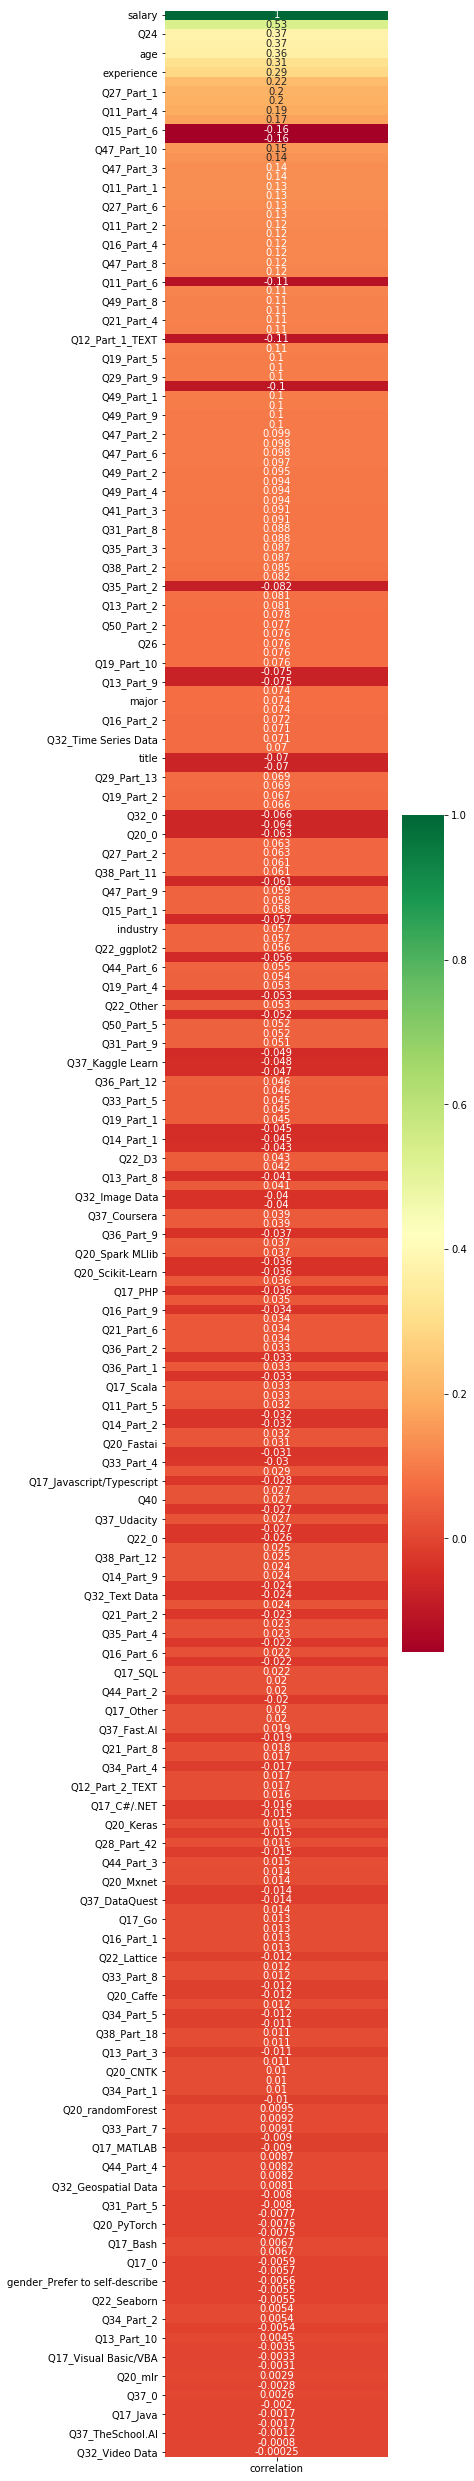

In [39]:
fig = plt.figure(figsize=(5,45))
fig.add_subplot(1,1,1)
sns.heatmap(Sal_correlations,annot=True,cmap='RdYlGn') #data.corr()-->correlation matrix

In [40]:
Sal_correlations.drop(['salary'], axis=0, inplace=True)
Sal_correlations['feature'] = Sal_correlations.index
Sal_correlations.index = range(256)
#Sal_correlations.reset_index(drop=True, inplace=True)

# find and print the top 10 features
correlation_top = Sal_correlations.head(10)
print(correlation_top)

   correlation         feature
0     0.531986  GDP per capita
1     0.372817             Q24
2     0.368722         country
3     0.363236             age
4     0.313191             Q25
5     0.293177      experience
6     0.223529             Q10
7     0.201812      Q27_Part_1
8     0.195628      Q15_Part_2
9     0.188871      Q11_Part_4


Text(0, 0.5, 'Feature')

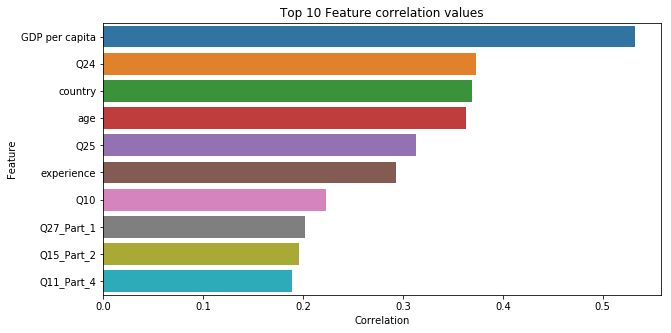

In [41]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,1,1)

sns.barplot(y='feature',x='correlation',data=correlation_top)

plt.title("Top 10 Feature correlation values")
plt.xlabel("Correlation")
plt.ylabel("Feature")

Clearly from the above plots, the attributes most related to a survey respondent's salary include:

##### GDP per capita

##### Q24 
How long have you been writing code to analyze data?

##### Country

##### Age

##### Q25 
For how many years have you used machine learning methods (at work or in school)? 

##### Experience

##### Q10 
Does your current employer incorporate machine learning methods into their business?

##### Q27_Part_1 
Which of the following cloud computing products have you used at work or school in the last 5 years (Select all 
that apply)? - Selected Choice - AWS Elastic Compute Cloud (EC2)

##### Q15_Part_2 
Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Amazon Web Services (AWS)

##### Q11_Part_4 
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas

### Data Visualization

In [42]:
Salaries_orig.head()

,gender,age,country,education,major,title,industry,experience,salary,Q10,...,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
0,Male,35,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Define all random seeds,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Male,21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,Make sure the code is well documented,Make sure the code is human-readable,NaN,Define relative rather than absolute file paths,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN
2,Male,34,Hungary,Master’s degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,3-4,21152,"We have well established ML methods (i.e., mod...",...,Make sure the code is well documented,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,Too time-consuming,NaN,Afraid that others will use my work without gi...,NaN,NaN
3,Male,41,United States of America,Master’s degree,Engineering (non-computer focused),Data Scientist,Other,5-10,132826,"We recently started using ML methods (i.e., mo...",...,Make sure the code is well documented,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN
4,Male,29,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,Academics/Education,1-2,35826,We are exploring ML methods (and may one day p...,...,Make sure the code is well documented,Make sure the code is human-readable,NaN,NaN,Include a text file describing all dependencies,Too time-consuming,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Country')

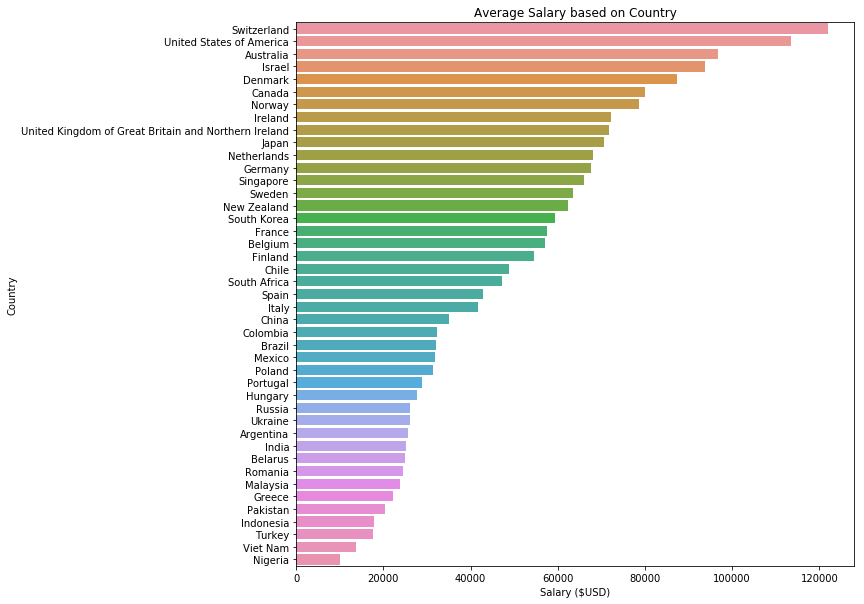

In [43]:
# Calculates salary per country
country_plot = Salaries_orig.groupby(['country'], as_index=False)['salary'].mean()
country_plot = country_plot.sort_values(by='salary', ascending=False)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
sns.barplot(x='salary',y='country',data=country_plot)
plt.title("Average Salary based on Country")
plt.xlabel("Salary ($USD)")
plt.ylabel("Country")

Text(0, 0.5, 'Mean Salary ($USD)')

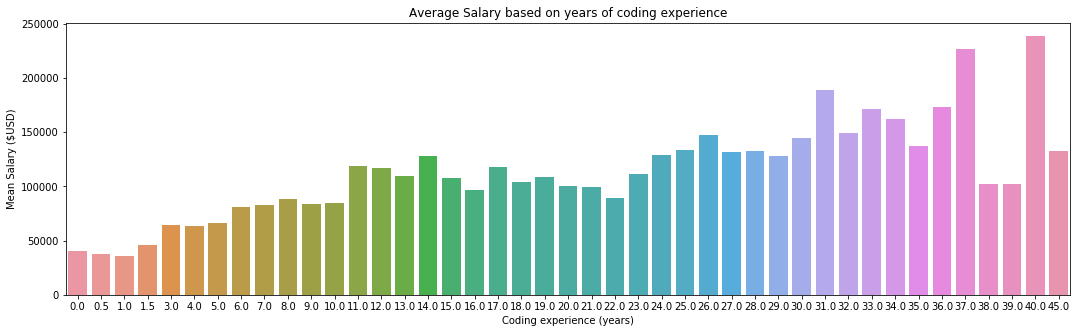

In [44]:
# Calculates compensation per Q24 - coding experience
Q24_plot = Salaries_orig.groupby(['Q24'], as_index=False)['salary'].mean()
Q24_plot = Q24_plot.sort_values(by='salary', ascending=False)
fig = plt.figure(figsize=(18,5))
fig.add_subplot(1,1,1)
sns.barplot(y='salary',x='Q24',data=Q24_plot)
plt.title("Average Salary based on years of coding experience")
plt.xlabel("Coding experience (years)")
plt.ylabel("Mean Salary ($USD)")

Text(0, 0.5, 'Mean Salary ($USD)')

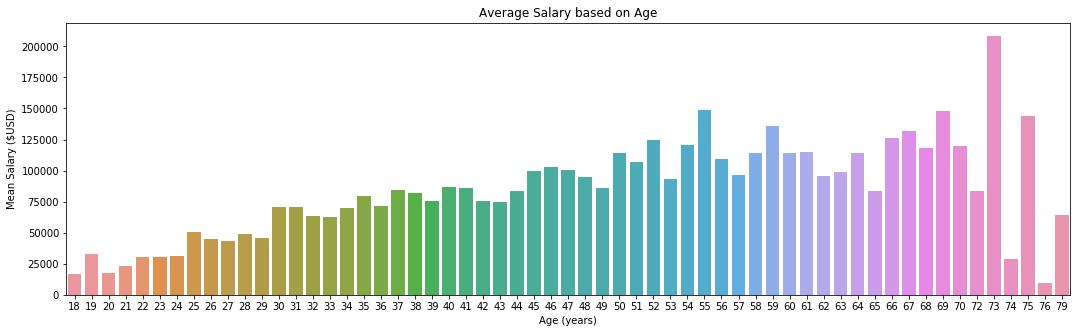

In [45]:
# Calculates compensation per age
age_plot = Salaries_orig.groupby(['age'], as_index=False)['salary'].mean()
fig = plt.figure(figsize=(18,5))
fig.add_subplot(1,1,1)
sns.barplot(y='salary',x='age',data=age_plot)
plt.title("Average Salary based on Age")
plt.xlabel("Age (years)")
plt.ylabel("Mean Salary ($USD)")

As you can see from the bar graphs above, there is a clear upward trend in Salary as a function of country, years of coding experience, and age. Clearly, the more years of experience with coding and the older you are, it is predicted you are to have a higher salary. Additionally, if the respondent indicates they live in Switzerland, the United States of America, or Australia they are more likely to have a higher salary than someone from Nigeria or Viet Nam.

## 3. Feature Selection

Feature engineering is the process of taking a dataset and constructing features that can be used to train a machine learning model for a prediction problem. Feature engineering is very useful when the intial variables are categorical and must be converted into some sort of numerical value to be processed by a regression model. For example, in an earlier step, I created a new column called GDP per capita and used a defined dictionary to map country to its GDP per capita. 
Feature selection is also important because if a dataset has a large set of features, it may take a long time to train the ML model and overfitting will most likely occur. Therefore, it is important to reduce the number of features while still retaining a high level of information.

In order to reduce the number of features, I will run random forest to determine feature importance. Then, drop features with a low importance value.

In order to reduce the number of features, first I will drop features with a correlation less than 0.01. This is a very low correlation value and means the feature has little affect on Salary. Therefore, the absence of these features should not affect the results.

In [46]:
Salaries_Y = Salaries['salary']
Salaries_X = Salaries
Salaries_X.drop(columns=['salary'], axis=1, inplace=True)

In [47]:
# Find features with a absolute value correlation to salary less than 0.05
corr_thresh = 0.05
low_corr = Sal_correlations[Sal_correlations['correlation'].abs() < corr_thresh].feature.tolist()

# drop low correlation features
Salaries_X.drop(low_corr, axis=1, inplace=True)

### Random Forest Feature Importance

In [48]:
model_RF=RandomForestRegressor(max_depth=10, n_estimators=100)
model_RF.fit(Salaries_X,Salaries_Y)
feature_importance_RF = pd.DataFrame(model_RF.feature_importances_, columns=['importance'])
feature_importance_RF['feature'] = Salaries_X.columns

Text(0, 0.5, 'Feature')

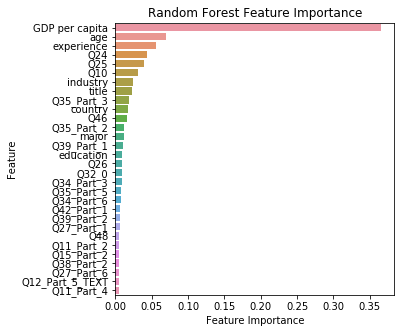

In [49]:
fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1)
sns.barplot(x='importance',y='feature',data=feature_importance_RF.sort_values(by=['importance'],ascending=False).head(30))
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

In [50]:
low_importance = feature_importance_RF[feature_importance_RF['importance'] < 0.005].feature.tolist()

In [51]:
Salaries_X.drop(low_importance, axis=1, inplace=True)

In [52]:
Salaries_X.shape
#Salaries_X.head()
#Salaries_Y.shape
#Salaries_X_train.shape
#Salaries_X_test.shape
#Salaries_Y_train.shape
#Salaries_Y_test.shape

(8576, 27)

In [53]:
Salaries_X_train, Salaries_X_test, Salaries_Y_train, Salaries_Y_test = train_test_split(Salaries_X, Salaries_Y, random_state=42, test_size=0.3)

## 4. Model Implementation

1. Lasso regularization (linear regression)
2. Gradient Boosting
3. KNN 
4. Random Forest

In [54]:
#set up cross validation
def run_kfold(model):
    
    X = Salaries_X_train
    Y = Salaries_Y_train
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    score = []
    mean_abs_err = []
    train_var = []
    train_bias = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        error = mean_absolute_error(Y_test, predictions)
        variance = np.var(predictions)
        bias = norm(predictions - Y_test)
        
        score.append(accuracy)
        mean_abs_err.append(error)
        train_var.append(variance)
        train_bias.append(bias)
        print("Fold {0} Accuracy: {1}".format(fold, accuracy))
        
    mean_score = np.mean(score)
    var_score = np.var(score)
    
    mean_error = np.mean(mean_abs_err)
    mean_var = np.mean(train_var)
    mean_bias = np.mean(train_bias)
    
    print("Mean Train Score: {0}".format(mean_score))
    print("Variance Score: {0}".format(var_score))
    #print("Mean Squared Error: {0}".format(mean_error))
    #print("Mean Variance: {0}".format(mean_var))
    #print("Mean Bias: {0}".format(mean_bias))
    
    return mean_score, var_score, mean_error, mean_var, mean_bias

### Lasso Regression

##### How it works:
Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds a penalty term to the loss function proportional to the absolute value of magnitude of coefficient. 
Lasso shrinks the less important feature’s coefficient to zero, thus removing these features altogether.  

##### Pros:
- fast
- easy to understand results
- less prone to overfitting
- good with numerical data with lots of features

##### Cons:
- unable to model complex relationships
- unable to capture nonlinear relationships without first transforming the inputs

In [55]:
model_lasso = linear_model.Lasso(alpha = 0.5,max_iter=10000)
mean_score_lasso, var_score_lasso, mean_error_lasso, mean_var_lasso, mean_bias_lasso = run_kfold(model_lasso)

Fold 1 Accuracy: 0.48955920451480295
Fold 2 Accuracy: 0.4647841835042993
Fold 3 Accuracy: 0.45754507157753266
Fold 4 Accuracy: 0.4321313459713212
Fold 5 Accuracy: 0.41709809077717663
Fold 6 Accuracy: 0.4470534802838111
Fold 7 Accuracy: 0.41450694966809565
Fold 8 Accuracy: 0.4339281777771027
Fold 9 Accuracy: 0.5035752415179471
Fold 10 Accuracy: 0.44417221973393783
Mean Train Score: 0.4504353965326027
Variance Score: 0.0007671371171141662


### Gradient Boosting

##### How it works:

Builds decision trees one at a time, where each new tree helps to correct errors made by the previously trained tree.

1. Build an initial decision tree based on a subset of the original dataset. This is referred to as the base model. Initially, all data points are given equal weights.
2. Make predictions on the whole dataset using base model.
3. Calculate errors using the actual and predicted values.
4. Higher weights are then given to observations which were incorrectly predicted
5. Multiple models are created, each correcting the errors of the previous model.
6. The final model (strong learner) is the weighted mean of all the models (weak learners).

##### Pros:
- provides very high predictive accuracy
- can be used to solve almost all objective functions 
- provides flexibility - easy to tune
- can control for both bias and variance
- works well with categorical and numerical values as is
- can handle missing data

##### Cons:

- more sensitive to overfitting if the data is noisy
- training generally takes longer because trees are built sequentially
- requires a large grid search during tuning

In [56]:
model_GB = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
mean_score_GB, var_score_GB, mean_error_GB, mean_var_GB, mean_bias_GB = run_kfold(model_GB)

Fold 1 Accuracy: 0.5717284112032545
Fold 2 Accuracy: 0.5312699158050133
Fold 3 Accuracy: 0.4882972106388893
Fold 4 Accuracy: 0.4914822436738375
Fold 5 Accuracy: 0.42718124628591747
Fold 6 Accuracy: 0.4695383557334023
Fold 7 Accuracy: 0.4343904451350208
Fold 8 Accuracy: 0.49159645032456034
Fold 9 Accuracy: 0.5499407107144861
Fold 10 Accuracy: 0.5050528812221964
Mean Train Score: 0.4960477870736578
Variance Score: 0.0019301402385645586


### K-Nearest Neighbours

##### How it works:
The algorithm uses feature similarity to predict values of any new data points in the test set. The new point is assigned a value based on how closely it resembles the points in the training set.

1. The distance between the new point and each training point is calculated.
2. The closest k data points are selected (based on the distance).
3. The average of these data points is the final prediction for the new point.

##### Pros:
- Simple to understand and easy to implement 
- Minimal parameter tuning required
- Fast

##### Cons:
- works well with small number of input variables but as the numbers of variables grow K-NN algorithm struggles to predict the output of new data point.
- very sensitive to outliers as it simply chooses the neighbors based on distance criteria.

In [57]:
model_KNN = neighbors.KNeighborsRegressor(n_neighbors = 10)
mean_score_KNN, var_score_KNN, mean_error_KNN, mean_var_KNN, mean_bias_KNN = run_kfold(model_KNN)

Fold 1 Accuracy: 0.39467236852497645
Fold 2 Accuracy: 0.3811592654675444
Fold 3 Accuracy: 0.4025268906917462
Fold 4 Accuracy: 0.3632845929126812
Fold 5 Accuracy: 0.2806491726722714
Fold 6 Accuracy: 0.34657512140989044
Fold 7 Accuracy: 0.29057018455981176
Fold 8 Accuracy: 0.3972757946707146
Fold 9 Accuracy: 0.4327661435109067
Fold 10 Accuracy: 0.41304141050301413
Mean Train Score: 0.3702520944923557
Variance Score: 0.0023213226394710835


### Random Forest

##### How it works:
The random forest algorithm randomly selects a set of features which are used to decide the best split at each node of the decision tree.

1. Random subsets are created from the original dataset (bootstrapping).
2. At each node in the decision tree, only a random set of features are considered to decide the best split.
3. A decision tree model is fitted on each of the subsets.
4. The final prediction is calculated by averaging the predictions from all decision trees.

##### Pros:
- Easy to tune
- more robust than a single decision tree
- less likely to overfit on the training data

##### Cons:
- a large number of trees may make the algorithm slow 
- random forests are biased in favor of attributes with more levels

In [58]:
model_RF = RandomForestRegressor(n_estimators=100, max_depth=10)
mean_score_RF, var_score_RF, mean_error_RF, mean_var_RF, mean_bias_RF = run_kfold(model_RF)

Fold 1 Accuracy: 0.5485121800097135
Fold 2 Accuracy: 0.49959166609541994
Fold 3 Accuracy: 0.4604875664995106
Fold 4 Accuracy: 0.46146627947673935
Fold 5 Accuracy: 0.38384878261735955
Fold 6 Accuracy: 0.45052358759832356
Fold 7 Accuracy: 0.41329424810952087
Fold 8 Accuracy: 0.4476728300406282
Fold 9 Accuracy: 0.5414902605290253
Fold 10 Accuracy: 0.4707932939042737
Mean Train Score: 0.46776806948805144
Variance Score: 0.0023780219129286026


In [59]:
Train_Score = [mean_score_lasso, mean_score_GB, mean_score_KNN, mean_score_RF]
Score_variance = [var_score_lasso, var_score_GB, var_score_KNN, var_score_RF]
Train_error = [mean_error_lasso, mean_error_GB, mean_error_KNN, mean_error_RF]
models = ['Lasso','Gradient Boosting', 'KNN','Random Forest']

results_df = pd.DataFrame({'Train Score Mean': Train_Score,'Score Variance':Score_variance, 'Train error': Train_error}, index = models)  

#### Summary of results

Random forest has the lowest error, however the gradient boosting algorithm has a higher accuracy score and lower variance. Lasso regression has the lowest variance, but a higher error, most likely meaning this algorithm has a higher bias. 
KNN had the worst results, with the lowest accuracy score and highest error.

In [60]:
results_df

,Train Score Mean,Score Variance,Train error
Lasso,0.450435,0.000767,27022.240882
Gradient Boosting,0.496048,0.001930,24788.347575
KNN,0.370252,0.002321,28831.969087
Random Forest,0.467768,0.002378,26071.495854


## 5. Model Tuning

In [61]:
def hyperparameter_tuning(model, parameters, metric):
    
    '''hyperparameter tuning using grid search method. Takes the model, parameters to tune, and metric
    on which to choose the optimal parameters as function arguments'''
    
    acc_scorer = make_scorer(metric)
    
    grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer, cv=5)
    grid_obj = grid_obj.fit(Salaries_X, Salaries_Y)
    gridsearch = grid_obj.best_estimator_
    
    fit = gridsearch.fit(Salaries_X, Salaries_Y)
    score = gridsearch.score(Salaries_X, Salaries_Y)
    
    return gridsearch, fit, score

### Lasso Regularization

Grid Search Score: 0.4556636897239118

Optimal parameters: Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=42, selection='cyclic',
   tol=0.0001, warm_start=False)

In [62]:
model = linear_model.Lasso(random_state=42)
parameters = {'alpha':[0.5,1,3, 5, 10], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} 
metric = r2_score

#lasso_optimal, lasso_fit, lasso_score = hyperparameter_tuning(model, parameters, metric)

### Gradient Boosting

Grid Search Score: 0.5789563478672761

Optimal parameters: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
model = GradientBoostingRegressor()

parameters = [{'loss': ['ls'],
               'n_estimators': [100, 500, 1000],
               'max_depth': [3, 5, 10]},
              
              {'loss': ['quantile'],
               'n_estimators': [100, 500, 1000],
               'max_depth': [3, 5, 10],
               'alpha': [0.9, 0.95, 0.99]}
             ]
metric = r2_score

#GB_optimal, GB_fit, GB_score = hyperparameter_tuning(model, parameters, metric)

### K-Nearest Neighbours
          
Grid Search Score: 0.4450565492495384

Optimal parameters: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=40, p=1,
          weights='uniform')

In [64]:
model = neighbors.KNeighborsRegressor(p=1)

parameters = [{'n_neighbors': [10, 20, 40, 60]
              }]
metric = r2_score
#KNN_optimal, KNN_fit, KNN_score = hyperparameter_tuning(model, parameters, metric)

### Random Forest

Grid Search Score: 0.9160464718603291

Optimal parameters: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
model = RandomForestRegressor()

parameters = [{'n_estimators': [100, 1000, 1500],
               'max_depth': [5, 10, 15]
              }]
metric = r2_score
#RF_optimal, RF_fit, RF_score = hyperparameter_tuning(model, parameters, metric)

## 6. Testing and Discussion

Using the grid search method, and comparing r2 accuracy scores, the random forest algorithm had the highest grid search score, therefore this algorithm is chosen as the optimal solution.

In [66]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

mean_score, var_score, mean_error, mean_var, mean_bias = run_kfold(model)

predictions = model.predict(Salaries_X_test)
test_error = mean_absolute_error(Salaries_Y_test, predictions)
Test_Score = r2_score(Salaries_Y_test, predictions)

print ("------------------\n Test Score: " + str(Test_Score))

Fold 1 Accuracy: 0.5546001357631182
Fold 2 Accuracy: 0.512826771247986
Fold 3 Accuracy: 0.46096522235617665
Fold 4 Accuracy: 0.4670720786303568
Fold 5 Accuracy: 0.38844108390639454
Fold 6 Accuracy: 0.44851307904024706
Fold 7 Accuracy: 0.4144846442909147
Fold 8 Accuracy: 0.4473791510956622
Fold 9 Accuracy: 0.5401417211622251
Fold 10 Accuracy: 0.4758328680411781
Mean Train Score: 0.47102567555342595
Variance Score: 0.002473208062241527
------------------
 Test Score: 0.5008458866499211


In [67]:
mean_error

26205.202511656753

In [68]:
test_error

26051.908722085234

### Summary of Results

Mean Train Score: 0.46067143385857523

Mean Train Error: 26289.227921664424

Test Score: 0.49929767791180213

Test Error: 26001.92855738829

The testing score is higher than the training score and the error is lower. This indicates the model is a good fit for both the training and testing datasets, and there is no overfitting occurring.

## Bonus

In [69]:
from sklearn.neural_network import MLPRegressor

In [70]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8,4), random_state=1, max_iter=1000)
clf.fit(Salaries_X, Salaries_Y)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 8, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [71]:
clf.score(Salaries_X, Salaries_Y)

0.39038474548815694

In [73]:
clf.score(Salaries_X_test, Salaries_Y_test)

0.40198352604587195